In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.insert(0,"..")
from profiler import *
from utils import *
from datasets import *
from models import *
from transforms import *
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')

Available workers: 16


Found 11136 in dataset: /home/kalfasyan/data/wingbeats/wingbeats_20211129/wingbeats_correct_dates/Melanogaster_202111_SD/, and 1 label(s): ['wingbeats_correct_dates']
Label(s) changed to [0]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..


 20%|██        | 4/20 [00:00<00:00, 36.39it/s]

Finished.


100%|██████████| 20/20 [00:00<00:00, 32.63it/s]


5903


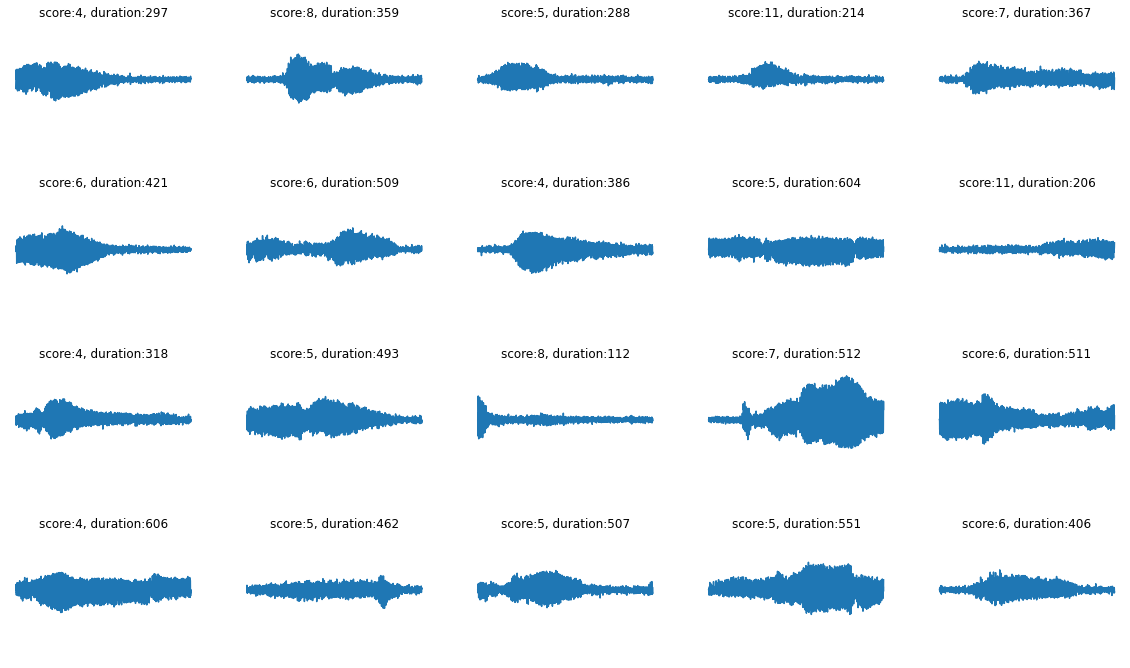

In [3]:
dspath = "/home/kalfasyan/data/wingbeats/wingbeats_20211129/wingbeats_correct_dates/Melanogaster_202111_SD/"

wbpf = WingbeatDatasetProfiler(dsname=dspath, custom_label=[0], rpiformat=False)

maxpeaks = 15
minpeaks = 1
maxscore = 12
minscore = 3.5
selection = f"peaks>{minpeaks} & peaks<{maxpeaks} & score>{minscore} & score<={maxscore}"
wbpf.df = wbpf.df.query(selection)
wbpf.plot_random_wbts()
print(wbpf.df.shape[0])


In [4]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

from tsfresh.examples.robot_execution_failures import download_robot_execution_failures


In [5]:
loaded_x = wbpf.df.x.apply(lambda x: open_wingbeat(x).numpy().squeeze())
x = pd.DataFrame(np.stack(loaded_x)) 
# df_tsf = pd.DataFrame(x.T)
# df_tsf['id'] = 1
# df_tsf['time'] = list(range(5000))
# df_tsf = df_tsf.iloc[:,-8:]

In [6]:
from tqdm import tqdm
all_subs = []
for i in tqdm(x.columns):
    sub = pd.DataFrame(x[i])
    sub.columns = ["F"]
    sub['id'] = i
    sub['time'] = list(range(len(x)))
    all_subs.append(sub)
    #if i > 2000:
#        break
# pd.concat(all_subs,axis=1)#.drop(['id','time'], axis=1)

100%|██████████| 5000/5000 [00:09<00:00, 528.51it/s]


In [7]:
extraction_settings = ComprehensiveFCParameters()

X = extract_features(pd.concat(all_subs), column_id='id', column_sort='time',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute,
                    n_jobs=16)

Feature Extraction: 100%|██████████| 80/80 [3:28:16<00:00, 156.21s/it]   


In [8]:
X.shape

(5000, 789)

In [13]:
x

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.001526,0.002045,0.003021,0.000397,0.001923,0.001373,0.001831,-0.000183,-0.000183,0.002045,...,0.006866,0.006653,0.004761,0.003754,0.003021,0.004456,0.003998,0.003082,0.003876,0.005493
1,0.004761,0.006866,0.007355,0.007996,0.007111,0.007721,0.007019,0.005646,0.002594,0.000671,...,0.004425,0.002136,0.004181,0.002045,0.001892,0.001251,0.003540,0.000916,0.000458,0.001068
2,-0.001007,0.000916,-0.000977,-0.002625,-0.000153,0.001556,0.001587,0.001801,0.003082,-0.000336,...,-0.000092,0.000793,0.000854,0.000885,-0.000641,0.001892,0.003845,-0.000153,-0.000092,0.001099
3,-0.004608,-0.001434,-0.000275,0.000214,-0.002045,-0.003845,-0.002899,-0.002228,-0.000031,0.000702,...,-0.008087,-0.004059,-0.001617,-0.003296,0.000580,0.001923,-0.001221,-0.003052,-0.003235,-0.006348
4,0.003510,0.001709,0.002014,0.002686,0.001251,0.001068,0.003601,0.001373,0.000732,0.001923,...,-0.000183,0.000549,0.001190,-0.000397,-0.000153,0.000427,-0.001068,-0.000061,0.001373,-0.000336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5898,-0.001862,-0.002045,-0.001923,-0.000946,0.000366,-0.002960,-0.004761,-0.004211,-0.005005,-0.003967,...,-0.003510,-0.002838,0.001648,0.004150,0.007568,0.007080,0.002808,0.000732,0.003021,-0.000946
5899,-0.001740,0.000641,0.000519,0.000549,0.001465,0.001953,0.001770,0.003601,0.004791,0.004608,...,-0.001221,-0.001526,0.000092,0.001709,-0.000977,0.000854,-0.000244,0.000488,0.000031,-0.003387
5900,0.000488,0.003082,-0.001434,-0.007019,-0.008148,-0.005707,-0.007202,-0.005432,-0.001160,-0.002594,...,0.007538,0.006653,0.009033,0.008850,0.006561,0.003387,0.004120,0.004761,0.002533,-0.001129
5901,0.000946,0.002960,0.000793,-0.000244,0.002014,0.000702,-0.002014,0.000092,-0.000366,-0.002167,...,-0.004791,-0.003296,-0.003235,-0.001617,0.000275,-0.002991,-0.003967,-0.003784,-0.001007,-0.003174
